In [1]:
import __init__
from functools import partial
import jax
from jax import numpy as jnp
from numpyro import distributions as dists
from matplotlib import pyplot as plt
from adim import *
plt.style.use('ggplot')

Adding '/Users/johannes/Projects/Optimal Thresholds for Approximate Analog In-Memory Computing' to path...


/Users/johannes/Projects/Optimal Thresholds for Approximate Analog In-Memory Computing/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class EmpiricalDistribution(dists.discrete.CategoricalProbs):
    def enumerate_support(self):
        return self._supp
    
    @property
    def has_enumerate_support(self):
        return True

    def __init__(self, support, probs, issorted=False, isnormalized=True):
        probs = jnp.atleast_1d(probs)
        support = jnp.atleast_1d(support)

        if not isnormalized:
            probs /= probs.sum()

        if not issorted:
            idx = jnp.argsort(support)
            support = support[idx]
            probs = probs[idx]

        super().__init__(probs=probs)

        self._supp = support
        self.empirical_cdf = jnp.cumsum(probs)

    def split(self, val):
        idx = self.get_left_index(val)
        d1 = EmpiricalDistribution(self._supp[:idx], self.probs[:idx], issorted=True, isnormalized=False)
        p1 = self.cdf(self._supp[idx])
        d2 = EmpiricalDistribution(self._supp[idx:], self.probs[idx:], issorted=True, isnormalized=False)
        return (
            p1, d1,
            1 - p1, d2
        )

    def get_left_index(self, x):
        return jnp.clip(0, jnp.searchsorted(self._supp, x, side="left"), len(self._supp)-1)

    def log_prob(self, x):
        idx = self.get_left_index(x)
        return jnp.where(self._supp[idx] == x, super().log_prob(idx), -jnp.inf)

    def cdf(self, x):
        """Compute the CDF of the empirical distribution at the given points.

        Args:
            x: The points at which to evaluate the CDF.
        
        Returns:
            The CDF at the given points.
        """
        idx = self.get_left_index(x)
        return self.empirical_cdf[idx]
    

    def icdf(self, x: jnp.ndarray) -> jnp.ndarray:
        """Compute the inverse CDF of the empirical distribution at the given points.

        Args:
            x: The points at which to evaluate the inverse CDF.

        Returns:
            The inverse CDF at the given points.
        """
        idx = jnp.searchsorted(self.empirical_cdf, x, side="right")
        idx_lower = jnp.clip(0, idx - 1, len(self._supp) - 2)
        return jnp.where(
            idx == 0,
            -jnp.inf,
            jnp.where(
                idx == len(self._supp),
                jnp.inf,
                (self._supp[idx_lower] + self._supp[idx_lower + 1]) / 2,
            ),
        )

In [3]:

def log_pdf_y_n(y, n, thresholds: jnp.ndarray, noise_std: float = 0.1):
    """
    Compute the log-probability of observing the quantized measurement y given the true integer product n.
    """
    shape = jnp.broadcast_shapes(
        thresholds.shape[:-1], jnp.shape(y), jnp.shape(n), jnp.shape(noise_std)
    )
    y = jnp.broadcast_to(y, shape)
    n = jnp.broadcast_to(n, shape)
    noise_std = jnp.broadcast_to(noise_std, shape)

    d = dists.Normal(n, noise_std)
    idx = jnp.ix_(*[jnp.arange(i) for i in shape])

    upper = thresholds[*idx, y + 1]
    lower = thresholds[*idx, y]
    return jnp.log((d.cdf(upper) - d.cdf(lower)))


def log_pdf_yn(
    P_n: dists.discrete.Distribution,
    y: jnp.ndarray,
    n: jnp.ndarray,
    thresholds: jnp.ndarray,
    noise_std: float = None
):
    """
    Compute the joint log-probability of observing the quantized measurement y and the true integer product n.
    """
    return log_pdf_y_n(y, n, thresholds, noise_std) + P_n.log_prob(n)


def log_pdf_y(
    P_n: dists.discrete.Distribution,
    y: jnp.ndarray,
    thresholds: jnp.ndarray,
    noise_std: float = None
):
    """
    Compute the log-probability of observing the quantized measurement y.
    """
    ns = P_n.enumerate_support()

    trial_dims = jnp.broadcast_shapes(
        jnp.shape(thresholds)[:-1], jnp.shape(noise_std), jnp.shape(y)
    )

    ns = ns[:, *(jnp.newaxis,) * len(trial_dims)]
    y = jnp.atleast_1d(y)[jnp.newaxis, ...]
    thresholds = jnp.atleast_1d(thresholds)[jnp.newaxis, ...]
    noise_std = jnp.atleast_1d(noise_std)[jnp.newaxis, ...]

    terms = log_pdf_yn(P_n, y, ns, thresholds, noise_std)
    return jax.scipy.special.logsumexp(terms, axis=0, keepdims=False)


@partial(jax.jit, static_argnames=("P_n", ))
def MI(
    P_n: dists.discrete.Distribution,
    thresholds: jnp.ndarray,
    noise_std: float = 0
):
    """
    Compute the mutual information between the quantized measurement y and the true product n.
    """

    trial_dims = jnp.broadcast_shapes(
        jnp.shape(thresholds)[:-1], jnp.shape(noise_std)
    )

    # map over all possible combinations of y and n
    ys = jnp.arange(thresholds.shape[-1] - 1)
    ns = P_n.enumerate_support()

    # add extra dimensions to ys and ns to sum over
    ys = ys[:, jnp.newaxis, *(jnp.newaxis,) * len(trial_dims)]
    ns = ns[jnp.newaxis, :, *(jnp.newaxis,) * len(trial_dims)]
    noise_std = jnp.array(noise_std)[jnp.newaxis, jnp.newaxis, ...]
    thresholds = thresholds[jnp.newaxis, jnp.newaxis, ...]

    # compute the probabilities
    l_p_y_n = log_pdf_y_n(ys, ns, thresholds, noise_std)
    l_p_y = log_pdf_y(P_n, ys, thresholds, noise_std)
    l_p_n = P_n.log_prob(ns)
    l_p_yn = l_p_n + l_p_y_n

    # compute the log of each summand term
    # log2(p_y_n/p_y) = log2(p_y_n) - log2(p_y) = (log(p_y_n) - log(p_y)) / log(2)
    summand = jnp.exp(l_p_yn) * (l_p_y_n - l_p_y) / jnp.log(2)

    # sum over all possible values of y and n where the probability is >0
    res = jnp.sum(summand, axis=(0, 1), keepdims=False, where=jnp.isfinite(summand))
    return res

In [4]:
from dataclasses import dataclass
import heapq

from tqdm import tqdm

def place_thresholds(dbase: dists.discrete.Distribution, num_bits):
    @dataclass
    class SubDistribution:
        d: dists.discrete.Distribution

        @property
        def priority(self):
            return jax.scipy.special.logsumexp(dbase.log_prob(self.d.enumerate_support()))+jnp.log(self.d.entropy())

        def __lt__(self, other: "SubDistribution"):
            return self.priority > other.priority

    heap = [SubDistribution(d)]

    for _ in tqdm(range(2**num_bits-1)):
        # take highest entropy chunk
        head = heapq.heappop(heap)
        dd = head.d

        if len(dd._supp) == 1:
            heapq.heappush(heap, head)
            # break
            continue

        # find the split position (should always slide off at least one value)
        if dd.probs[0] > 0.5:
            pos = (dd._supp[0]+dd._supp[-1])/2
        else:
            pos = dd.icdf(0.5)
            
        # split it into two halves
        _,d1,_,d2 = dd.split(pos)
        child1 = SubDistribution(d1)
        child2 = SubDistribution(d2)

        # add the two halves back to the heap
        heapq.heappush(heap, child1)
        heapq.heappush(heap, child2)

    
    thresholds_min = []
    thresholds_max = []
    for v in heap:
        thresholds_min.append(v.d._supp[0])
        thresholds_max.append(v.d._supp[-1])
    thresholds_min = jnp.array(sorted(thresholds_min))
    thresholds_max = jnp.array(sorted(thresholds_max))
    thresholds = (thresholds_max[:-1] + thresholds_min[1:])/2
    thresholds = jnp.concatenate([jnp.array([-jnp.inf]), thresholds, jnp.array([jnp.inf])])
    return thresholds

In [5]:

def find_optimal(
    num_bits,
    dist: dists.discrete.Distribution,
    noise_std: float = 0.0,
    linear: bool = False,
    num_scale_samples: int = 100,
    offset_increment: float = 0.5,
) -> "Quantizer":
    """Compute the optimal bin placement for the given empirical PDF.

    Args:
        num_bits: The number of bits to use for the bin index.
        dist: The empirical distribution to quantize.
        linear: Whether to use a linear bin placement.

    Returns:
        The optimal bin placement as a Quantizer object.
    """

    if linear:
        # do grid-search to find optimal scale and offset
        # min_scale: all values fit inside one bin ->
        min_scale = jnp.diff(dist.enumerate_support()).min() / (2**num_bits)
        # max_scale: all bins fit between two values ->
        max_scale = dist.support.upper_bound - dist.support.lower_bound
        scales = jnp.logspace(
            jnp.log(min_scale), jnp.log(max_scale), num_scale_samples
        )
        offsets = jnp.arange(
            dist.support.lower_bound, dist.support.upper_bound, offset_increment, dtype=jnp.float32
        )

        # find optimum by sweeping
        MIs = sweep(dist, num_bits, offsets, scales, noise_std)

        # compute optimum
        max_idx = MIs.argmax()
        max_scale_idx, max_phase_idx = jnp.unravel_index(max_idx, MIs.shape)
        max_scale = scales[max_scale_idx]
        max_phase = offsets[max_phase_idx]
        max_MI = MIs[max_scale_idx, max_phase_idx]

        # recreate the optimal thresholds
        thresholds = compute_even_levels(
            num_bits, max_scale, max_phase, offset_fixed=dist.mean
        )
    else:
        thresholds = place_thresholds(dist, num_bits)

    # compute the mutual information between the input and output
    return MI(dist, thresholds, noise_std), thresholds

In [6]:
d1 = dists.Binomial(256, 0.25)
d2 = dists.Binomial(256, 0.75)
support = d1.enumerate_support()
logp1 = d1.log_prob(support)
logp2 = d2.log_prob(support)
support = ((support - support.mean())*2).astype(int)
d = EmpiricalDistribution(support, 0.5*jnp.exp(logp1)+0.5*jnp.exp(logp2))

100%|██████████| 31/31 [00:08<00:00,  3.79it/s]


33

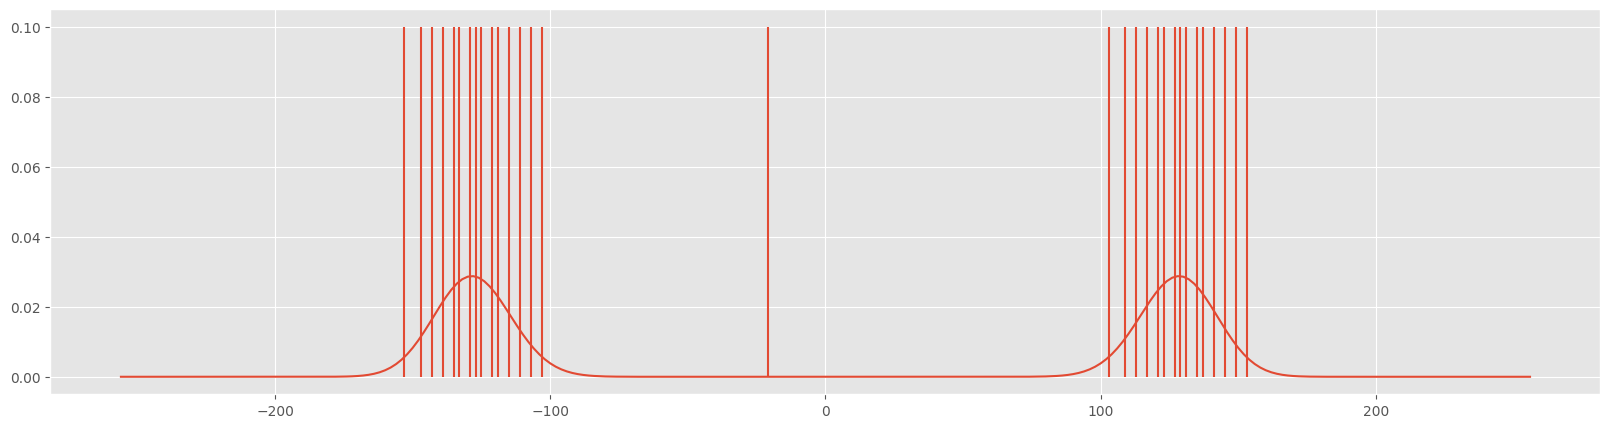

In [7]:
thresholds = place_thresholds(d, 5)

plt.figure(figsize=(20, 5))
plt.vlines(thresholds, 0.0, 0.1)
plt.plot(d.enumerate_support(), d.probs)
len(thresholds)

In [8]:
mi,theta = find_optimal(6, d, noise_std=0.1, linear=False)
print(f"MI: {mi:.2f}, H: {d.entropy()/jnp.log(2):.2f}")

100%|██████████| 63/63 [00:03<00:00, 19.54it/s] 


MI: 5.74, H: 5.84


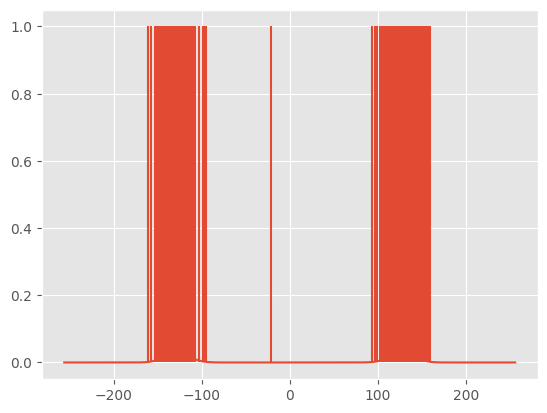

In [9]:
plt.plot(d._supp, jnp.exp(d.log_prob(d._supp)))
plt.vlines(theta, 0, 1)
# plt.xlim(-50,50)

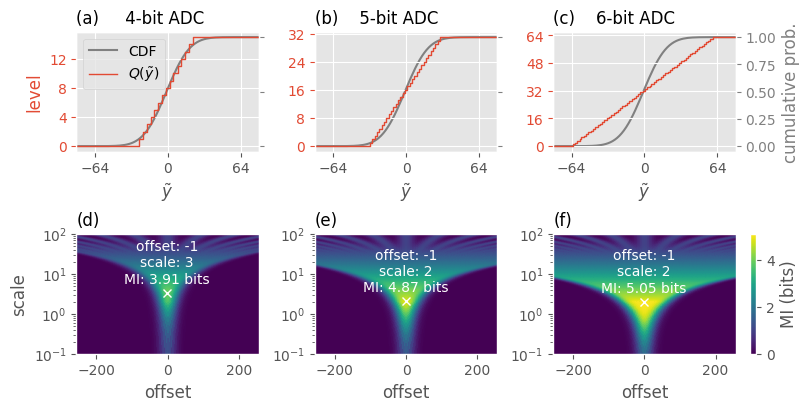

In [10]:

# create the figure
from matplotlib.ticker import MultipleLocator


fig, ax = plt.subplots(2, 3, figsize=(8, 4), layout="constrained")
# share_axis(ax[:,:-1], sharex="row", sharey="row")

vector_length = 256
self = dists.Binomial(vector_length, 0.5)
support = jnp.array(self.enumerate_support())*2 - vector_length
probabilities = jnp.exp(self.log_prob(self.enumerate_support()))

phase = jnp.linspace(-vector_length, vector_length, 1000)
scale = jnp.logspace(-1, 2, 1000)


vmin, vmax = 0, jnp.log2(4*jnp.pi*jnp.e)

cases = [("(a)     4-bit ADC", "(d)", 4),("(b)    5-bit ADC", "(e)", 5),("(c)    6-bit ADC", "(f)", 6)]
for i,(label1, label2, bits) in enumerate(cases):
    # compute MI for different scales and phases
    MIs = MI_nonoise(*jnp.ix_(scale, phase), 2**bits, support, probabilities)
    
    # compute optimum
    max_idx = MIs.argmax()
    max_scale_idx, max_phase_idx = jnp.unravel_index(max_idx, MIs.shape)
    max_scale = scale[max_scale_idx]
    max_phase = phase[max_phase_idx]
    max_MI = MIs[max_scale_idx, max_phase_idx]

    ax_cdf, ax_fun, lines = plot_quantization(ax[0,i], vector_length, bits, max_scale, max_phase, color=f"C0", yticklocator=MultipleLocator(2**(bits-2)))
    ax_sweep, im = plot_sweep(ax[1,i], phase, scale, MIs, annotate=(max_phase, max_scale, max_MI), vmin=vmin, vmax=vmax, cmap="viridis", rasterized=True)
    
    if i != 0:
        ax_fun.yaxis.label.set_visible(False)

    if i == 2:
        ax_cdf.yaxis.label.set_visible(True)
        ax_cdf.set_yticks([0,0.25,0.5,0.75,1.0])
    else:
        ax_cdf.yaxis.label.set_visible(False)
        plt.setp(ax_cdf.get_yticklabels(), visible=False)

    # im = plot_sweep()

    labels = [l.get_label() for l in lines]

    ax_fun.set_xlim(-80,80)
    ax_fun.set_title(label1, fontsize=12, loc="left")
    ax_sweep.set_title(label2, fontsize=12, loc="left")
    ax_sweep.set_xlabel("offset")

    if i == 0:
        ax_fun.legend(handles=lines, labels=labels, loc="upper left", fancybox=True, ncol=1)
    

fig.colorbar(im, ax=ax[1,:], label="MI (bits)", pad=-0.075)
# place legend in axis, hide everything else
# ax[0,-1].axis("off")

ax[1, 0].set_ylabel("scale")

fig.savefig("../figures/optimum.pdf", bbox_inches="tight")
fig.savefig("../figures/optimum.svg", bbox_inches="tight")
fig.savefig("../figures/optimum.png", bbox_inches="tight", dpi=300)